<a href="https://colab.research.google.com/github/bratati30/handwritten-tect-recognition/blob/main/RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!unzip gdrive/My\Drive/IAM/WORDS.zip

In [ ]:
from  tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Reading and processing the word samples:

In [ ]:
path = '/content/gdrive/MyDrive/IAM'
words_l = []

words = open(f"{path}/WORDS.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":
        words_l.append(line)

len(words_l)
#np.random.shuffle(words_l)
words_l[0:10]


['a01-000u-00-00 ok 154 408 768 27 51 AT A\n',
 'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE\n',
 'a01-000u-00-02 ok 154 796 764 70 50 TO to\n',
 'a01-000u-00-03 ok 154 919 757 166 78 VB stop\n',
 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.\n',
 'a01-000u-00-05 ok 154 1438 746 382 73 NP Gaitskell\n',
 'a01-000u-00-06 ok 154 1896 757 173 72 IN from\n',
 'a01-000u-01-00 ok 156 395 932 441 100 VBG nominating\n',
 'a01-000u-01-01 ok 156 901 958 147 79 DTI any\n',
 'a01-000u-01-02 ok 156 1112 958 208 42 AP more\n']

# Splitting the dataset into training, validation, and test subsets:

In [ ]:
split_ratio = 0.8  # 80% for training
val_ratio = 0.1    # 10% for validation
test_ratio = 0.1   # 10% for testing

split_idx = int(split_ratio * len(words_l))
train_samples = words_l[:split_idx]

remaining_samples = words_l[split_idx:]
val_split_idx = int(val_ratio * len(remaining_samples))
validation_samples = remaining_samples[:val_split_idx]
test_samples = remaining_samples[val_split_idx:]

assert len(words_l) == len(train_samples) + len(validation_samples) + len(test_samples)
print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")


Total training samples: 77164
Total validation samples: 1929
Total test samples: 17363


# Defining the base image path and preparing image paths and labels:

In [ ]:
base_image_path = os.path.join('/content/words')

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip().split(" ")
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(base_image_path, partI, partI + "-" + partII, image_name + ".png")
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])
    return paths, corrected_samples

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_samples = get_image_paths_and_labels(test_samples)

train_img_paths[0:10]

['/content/words/a01/a01-000u/a01-000u-00-00.png',
 '/content/words/a01/a01-000u/a01-000u-00-01.png',
 '/content/words/a01/a01-000u/a01-000u-00-02.png',
 '/content/words/a01/a01-000u/a01-000u-00-03.png',
 '/content/words/a01/a01-000u/a01-000u-00-04.png',
 '/content/words/a01/a01-000u/a01-000u-00-05.png',
 '/content/words/a01/a01-000u/a01-000u-00-06.png',
 '/content/words/a01/a01-000u/a01-000u-01-00.png',
 '/content/words/a01/a01-000u/a01-000u-01-01.png',
 '/content/words/a01/a01-000u/a01-000u-01-02.png']

In [ ]:
train_labels[0:10]

['a01-000u-00-00 ok 154 408 768 27 51 AT A',
 'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE',
 'a01-000u-00-02 ok 154 796 764 70 50 TO to',
 'a01-000u-00-03 ok 154 919 757 166 78 VB stop',
 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.',
 'a01-000u-00-05 ok 154 1438 746 382 73 NP Gaitskell',
 'a01-000u-00-06 ok 154 1896 757 173 72 IN from',
 'a01-000u-01-00 ok 156 395 932 441 100 VBG nominating',
 'a01-000u-01-01 ok 156 901 958 147 79 DTI any',
 'a01-000u-01-02 ok 156 1112 958 208 42 AP more']

# Cleaning and preprocessing the labels:

In [ ]:
train_labels_cleaned=[]
characters=set()
max_len=0

for label in train_labels:
  label=label.split(" ")[-1].strip()
  for char in label:
    characters.add(char)
  max_len=max(max_len,len(label))
  train_labels_cleaned.append(label)

print("MAX LENGTH:",max_len)
print("Vocab size:",len(characters))
train_labels_cleaned[:15]

MAX LENGTH: 21
Vocab size: 78


['A',
 'MOVE',
 'to',
 'stop',
 'Mr.',
 'Gaitskell',
 'from',
 'nominating',
 'any',
 'more',
 'Labour',
 'life',
 'Peers',
 'is',
 'to']

# Clean the validation and test labels also

In [ ]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_samples)

print(test_labels_cleaned)

['we', 'were', 'not', 'back', 'for', 'Christmas', 'as', 'arranged', ',', 'but', 'he', 'consoled', 'himself', 'by', 'thinking', 'that', 'he', 'and', 'Angelina', 'would', 'have', 'plenty', 'of', 'time', 'together', 'in', 'the', 'future', '.', 'And', 'Heaven', 'alone', 'knew', 'when', ',', 'if', 'ever', ',', 'he', 'would', 'be', 'back', 'on', 'Moon', 'again', ',', 'and', 'able', 'to', 'do', 'research', 'at', 'first', 'hand', 'into', 'matters', 'on', 'which', 'the', 'future', 'of', 'everyone', ',', 'including', 'Angelina', ',', 'depended', '...', 'expenses', ',', 'with', 'the', 'people', 'to', 'whom', 'Moke', 'had', 'sent', 'him', ':', 'little', 'people', 'who', 'regarded', 'him', 'as', 'lucky', 'to', 'have', 'descended', 'from', 'such', 'economic', 'altitudes', '.', 'Tom', 'Dreyfus', 'had', 'a', 'job', 'on', 'the', 'machines', 'in', 'the', 'Secretariat', '(', 'Stamp', 'Department', ')', 'while', 'Sally', 'sulked', 'at', 'home', '.', 'They', 'had', 'been', 'married', 'for', 'six', 'years',

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers
char_to_num = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

PREPARE TF.DATA.DATASET OBJECTS

In [ ]:
train_ds=prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds=prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds=prepare_dataset(test_img_paths,test_labels_cleaned)

In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check the amount of padding needed to be done
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do some amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[[pad_height_top, pad_height_bottom], [pad_width_left, pad_width_right], [0, 0]]
    )
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


# PUTTING THE UTILITIES TOGETHER

In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, image_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = distortion_free_resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length  # Define max_len
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(process_images_labels, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(batch_size).cache().prefetch(AUTOTUNE)
    return dataset



Visualising samples

<function matplotlib.pyplot.show(close=None, block=None)>

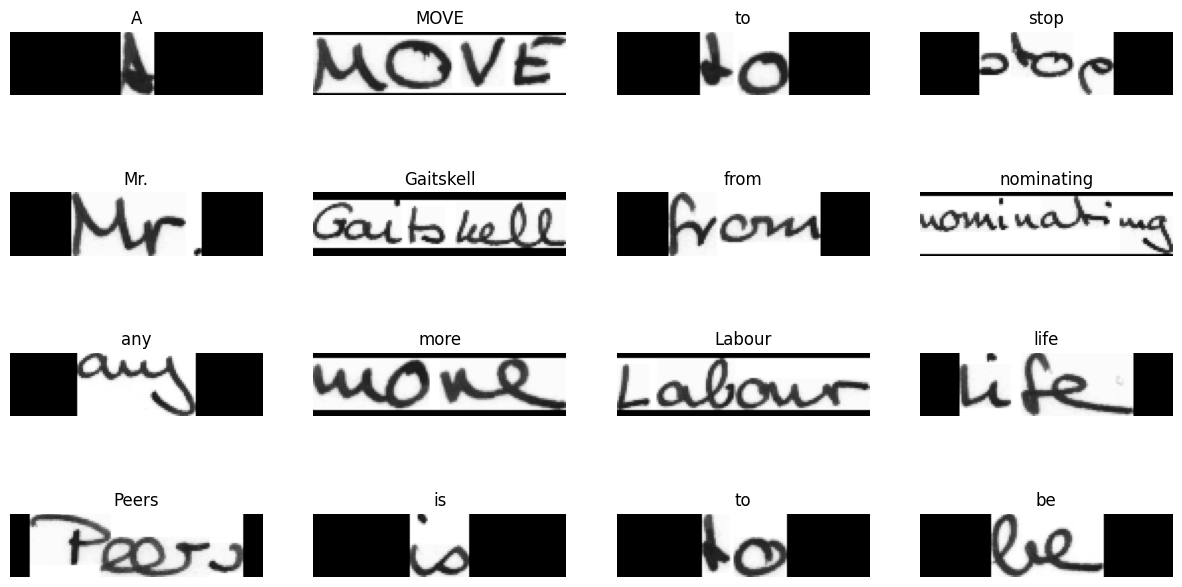

In [ ]:
for path in train_ds.take(1):
    images, labels = path['image'], path['label']
    _, ax = plt.subplots(4, 4, figsize=(15, 8))


for i in range(16):
  img=images[i]
  img=tf.image.flip_left_right(img)
  img=tf.transpose(img,perm=[1,0,2])
  img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)

  img=img[:, :, 0]

  #gather indices where labels != padding_token.

  label=labels[i]
  indices=tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))

  #convert to string
  label = tf.strings.reduce_join(num_to_char(indices))

  label=label.numpy().decode("utf-8")

  ax[i // 4, i % 4].imshow(img,cmap="gray")
  ax[i // 4, i % 4].set_title(label)
  ax[i // 4, i % 4].axis("off")

plt.show




# MODEL

In [ ]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # at test time, just return the computed prediction
        return y_pred

# Build the model
def build_model():
    # inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # first conv block
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # second conv block
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # filtering in the last layer is 64. reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss
    # the recommendation comes here
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Add accuracy metric
    accuracy_metric = keras.metrics.SparseCategoricalAccuracy(name='accuracy')


    # optimizer
    opt = keras.optimizers.Adam()
    # compile the model and return
    model.compile(optimizer=opt)
    model.compile(optimizer=keras.optimizers.Adam())
    return model

# get the model
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

In [ ]:
model.input

[<KerasTensor: shape=(None, 128, 32, 1) dtype=float32 (created by layer 'image')>,
 <KerasTensor: shape=(None, None) dtype=float32 (created by layer 'label')>]

In [ ]:
model.output

<KerasTensor: shape=(None, 32, 81) dtype=float32 (created by layer 'ctc_loss')>

EVALUATION METRIC


We first segregate the validation images and their for convenience

In [ ]:
validation_images=[]
validation_labels=[]

for batch in validation_ds:
  validation_images.append(batch["image"])
  validation_labels.append(batch["label"])

Now, we create a callback to monitor he edit distances

# TRAINING

2/2 [==============================] - 0s 12ms/step


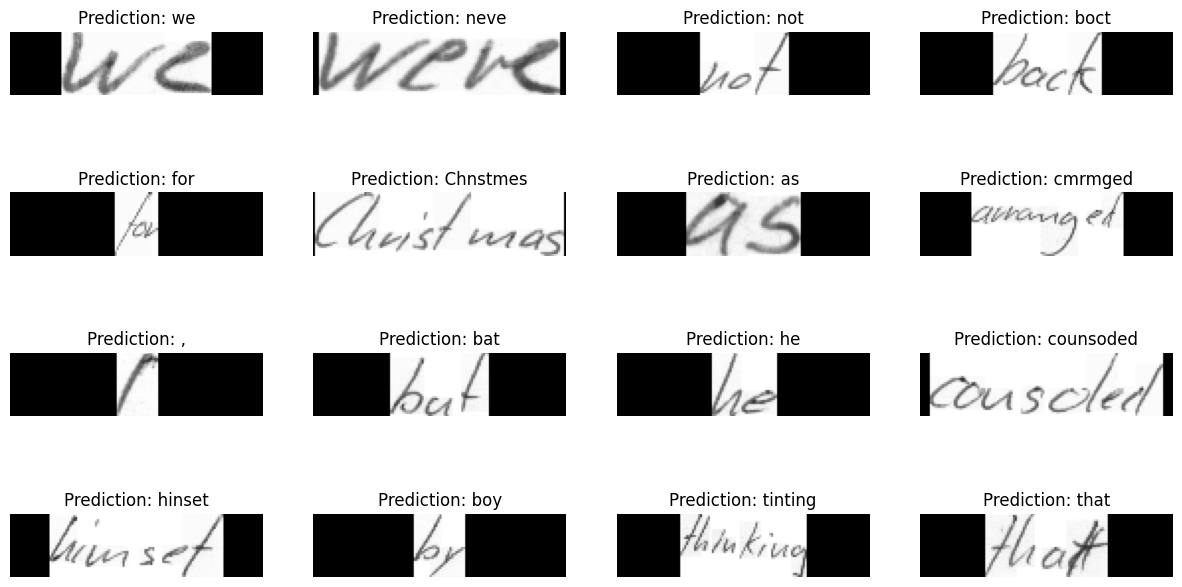

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:, :max_len]

    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()



**epoch**

In [ ]:
def calculate_edit_distance(labels, predictions):
    # Convert labels to sparse tensors
    sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out
    edit_distances = tf.edit_distance(
        sparse_predictions, sparse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)

In [ ]:
class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}")

epochs = 15

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.reverse(image, axis=[1])
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check the amount of padding needed to be done
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do some amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[[pad_height_top, pad_height_bottom], [pad_width_left, pad_width_right], [0, 0]]
    )

    image = tf.transpose(image, perm=[1, 0, 2])

    return image


In [ ]:
import tensorflow as tf

def preprocess_image(image_path, image_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = distortion_free_resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def recognize_word(model, image_path, num_to_char):
    # Preprocess the input image
    image = preprocess_image(image_path)

    # Expand dimensions to create a batch of size 1
    image_batch = tf.expand_dims(image, axis=0)

    # Make predictions using the model
    predictions = model.predict(image_batch)
    pred_texts = decode_batch_predictions(predictions)

    # Convert the predicted labels to text
    recognized_word = pred_texts[0]

    return recognized_word

image_path = '/content/words/b06/b06-000/b06-000-00-07.png'  # Replace with the path to your input image
recognized_word = recognize_word(prediction_model, image_path, num_to_char)
print(f"Recognized word: {recognized_word}")

